# Data Augmentation
Since we have a limited amount of data for each class (~20 images per class), it would be nice to use some data augmentation techniques to expand our dataset. We can apply transformations on our images to create new images to train on. This will help with overfitting as well as generalization to new data.

Let's start by importing the necessary modules:

In [1]:
import os

import numpy as np

import cv2
from matplotlib import pyplot as plt
import pandas as pd

## Defining Transformations
Here, we define some transformations. Each takes an image and returns the transformed image in the form of a NumPy array. I chose transformations that might happen in real life. 

We'll explore what each of these transformations look like, so feel free to [skip past the definitions](#Visualizing-Transformations):

In [16]:
# Define some data transformations
# Note: Only used cv2 here, but for other augmentations look here:
# http://www.scipy-lectures.org/advanced/image_processing/

def apply_blur(image, size=7, sig=0.788):
    """Returns a image with random Gaussian blur applied.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    size                (int): Size for Gaussian blur.

    sig               (float): Maximum sig for Gaussian blur.
    """
    size = (size, size)
    image = cv2.GaussianBlur(image, size, sig, sig)

    return image

def apply_hue_add(image, min_add=0, max_add=10):
    """Returns an image with random hue add.
    image     (numpy.ndarray): Image in the form of 3d array to apply noise to.

    min_add          (int): Minimum amount of add
    max_add          (int): Maximum amount of add.
    """

    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[:, :, 0] += np.uint8(np.random.random() * (max_add - min_add)) + min_add
    
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def apply_saturation(image, min_scale=0.8, max_scale=1.2):
    """Returns an image with random hue scale.
    image     (numpy.ndarray): Image in the form of 3d array to apply noise to.

    min_scale          (int): Minimum scale amount
    max_scale          (int): Maximum scale amount.
    """
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    scale = np.random.random() * (max_scale - min_scale) + min_scale
    new_saturation = image[:, :, 1]  * scale
    image[:, :, 1] = np.clip(new_saturation, 0, 255).astype('uint8')
    
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def apply_brightness(image, min_add=0, max_add=120):
    """Returns an image with random brightness add.
    image     (numpy.ndarray): Image in the form of 3d array to apply noise to.

    min_add          (int): Minimum amount of add
    max_add          (int): Maximum amount of add.
    """

    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    new_value = image[:, :, 2]  + np.random.random() * (max_add - min_add) + min_add
    image[:, :, 2] = np.clip(new_value, 0, 255).astype('uint8')
 
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

def apply_sp_noise(image, prob=0.20, sp_ratio=0.5):
    """Returns a image with random salt and pepper noise applied.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    p                 (float): Probability of adding either salt or pepper to a pixel.

    sp_ratio          (float): Ratio between salt and pepper.
    """
    salt_prob = prob * sp_ratio

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            for k in range(image.shape[2]):
                random = np.random.random()
                if random <= salt_prob:
                    image[i,j,k] = 255
                elif random <= prob:
                    image[i,j,k] = 0 

    return image

# Add some custom transformations for data augmentation
def apply_gauss_noise(image, mean=0, std=30):
    """Returns a image with random Gaussian noise applied.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    mean              (float): Mean for Gaussian noise.

    std               (float): Standard deviation for Gaussian noise.
    """

    noise = np.random.normal(mean, std, image.shape)
    image = np.add(image, noise.astype('int'))
    image = np.clip(image, 0, 255)

    return image

def apply_random_rotate(image, degrees=180):
    """ Returns an image rotated by a random degree.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    degrees           (float): Rotation by random amount will be in range [-degrees, +degrees].
    """
    width = image.shape[1]
    height = image.shape[0]
    
    to_rotate = 2 * np.random.random() * degrees - degrees
    M = cv2.getRotationMatrix2D((width / 2, height / 2), to_rotate, 1)
    image = cv2.warpAffine(image, M, (width, height))

    return image

def apply_random_translate(image, max_ratio=0.30):
    """ Returns an image translated by a random amount.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    max_ratio         (float): Translation amount will be in range [-max_ratio, max_ratio] * size.
    """
    side_length = image.shape[0]
    max_trans = side_length * max_ratio

    x_trans = 2 * np.random.random() * max_trans - max_trans
    y_trans = 2 * np.random.random() * max_trans - max_trans

    M = np.float32([[1, 0, x_trans],
                     [0, 1, y_trans]]) 
   
    image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

    return image

def apply_random_crop_resize(image, min_ratio=0.20, max_ratio=0.40):
    """ Returns an image cropped and resized by a random amount.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    max_ratio         (float): Crop resize amount will be in range [-max_ratio, max_ratio] * size.
    """
    width = image.shape[1]
    height = image.shape[0]
    
    ratio = np.random.random() * (max_ratio - min_ratio) + min_ratio

    x_margin = int(ratio * width // 2)
    y_margin = int(ratio * width // 2)


    x_lower, x_upper = x_margin, width - x_margin
    y_lower, y_upper = y_margin, height - y_margin

    cropped_image = image[y_lower:y_upper, x_lower:x_upper]
    resized_image = cv2.resize(cropped_image, (width, height))

    return resized_image

def apply_shear(image, degrees=20):
    """ Returns an image sheared by a random degrees.
    image     (numpy.ndarray): Image in the form of 3d array to apply transformation to.
    
    degrees           (float): Random shear amount will be in range [-degrees, +degrees].
    """
 
    width = image.shape[1]  
    height = image.shape[0]  

    x_center = width // 2
    y_center = height // 2

    to_rotate = 2 * np.random.random() * degrees - degrees
    to_rotate_rad = (2 * np.pi / 360) * to_rotate
    shift_amt = y_center * np.tan(to_rotate_rad)

    pts1 = np.float32([ [0, y_center], 
                        [width, y_center], 
                        [x_center, height]])
    
    pts2 = np.float32([ [0, y_center], 
                        [width, y_center], 
                        [x_center + shift_amt, height]])    

    M = cv2.getAffineTransform(pts1, pts2)

    image = cv2.warpAffine(image, M, (width, height))

    return image

def apply_color_jitter(image, hue_range=[0, 10], 
    saturation_range=[0.8, 1.2], brightness_range=[0, 100]):
    """ Returns an image with random color jitter.
    image              (numpy.ndarray): Image in the form of 3d array to be transformed.
    
    hue_range             ([int, int]): Range [min, max] to add to hue.
    saturation_range  ([float, float]): Range [min, max] to scale saturation.
    brightness_range      ([int, int]): Range [min, max] to add to brightness.
    """
    image = apply_hue_add(image, *hue_range)
    image = apply_saturation(image, *saturation_range)
    image = apply_brightness(image, *brightness_range)

    return image

def apply_affine(image, rotation=180, translate_ratio=0.3, 
                 crop_ratio=[0.0, 0.30], shear=20):
    """ Returns an image with random affine transformation.
    image         (numpy.ndarray): Image in the form of 3d array to be transformed.
    
    rotation                (int): Degrees in range [-rotation, rotation] to be rotated.
    translate_ratio       (float): Ratio amount to be translated.
    crop_ratio   ([float, float]): Range [min, max] factor to be cropped out.
    shear                   (int): Degrees in rante [-shear, shear] to apply shear with.
    """
    image = apply_shear(image, shear)
    image = apply_random_translate(image, translate_ratio)
    image = apply_random_crop_resize(image, *crop_ratio)
    image = apply_random_rotate(image, rotation)

    return image

## Visualizing Transformations
Let's look at what each of these transformations looks like:

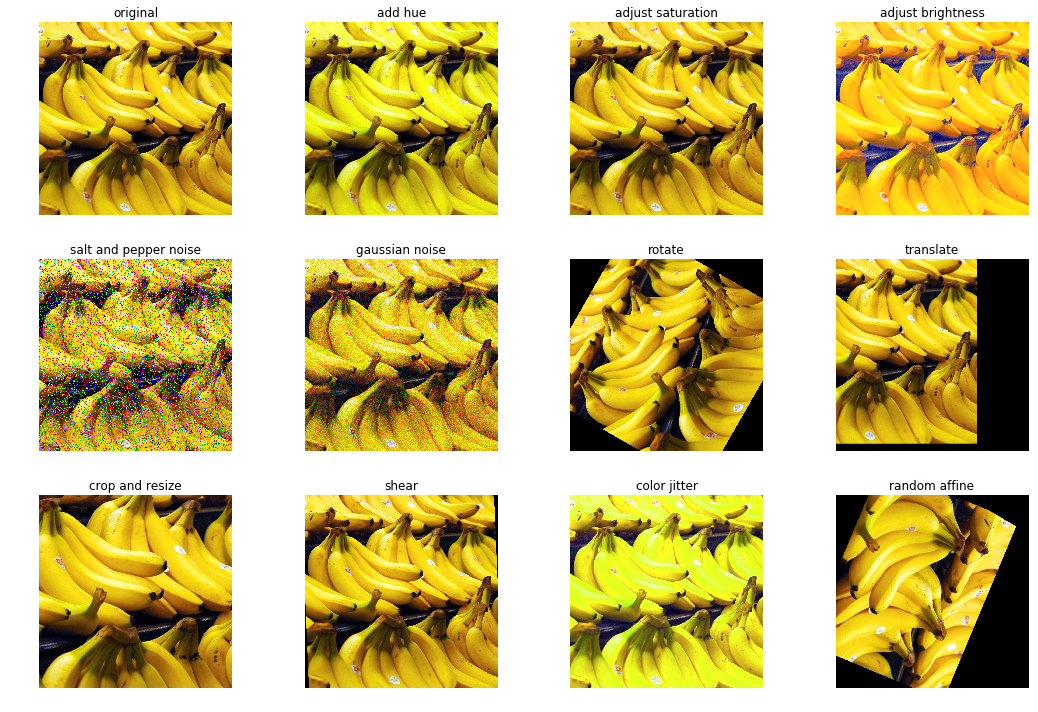

In [36]:
image_file = '../database/cropped/bananas/1.jpg'
transforms = [
    (lambda x: x, "original"),
    (apply_hue_add, "add hue"),
    (apply_saturation, "adjust saturation"),
    (apply_brightness, "adjust brightness"),
    (apply_sp_noise, "salt and pepper noise"),
    (apply_gauss_noise, "gaussian noise"),
    (apply_random_rotate, "rotate"),
    (apply_random_translate, "translate"),
    (apply_random_crop_resize, "crop and resize"),
    (apply_shear, "shear"), 
    (apply_color_jitter, "color jitter"),
    (apply_affine, "random affine")
]

n_transforms = len(transforms)
cols = 4
rows = np.ceil(n_transforms / cols)

plt.figure(figsize=(15, 10))
for i, (transform, name) in enumerate(transforms):
    image = cv2.imread(image_file) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(transform(image))
    plt.axis('off')
    plt.title(name)
    
plt.tight_layout()

These transformations will be copied into a `dataloader.py` file along with a DataLoader class which will allow for batch training and train time data augmentation.